In [19]:
xseed=1992

from numpy.random import seed

seed(xseed)

from tensorflow import set_random_seed

set_random_seed(xseed)

In [20]:
# model averaging ensemble and a study of ensemble size on test accuracy
from sklearn.datasets import make_blobs

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.constraints import maxnorm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score

from matplotlib import pyplot

from numpy import array
from numpy import argmax
import numpy
import pandas

import os
from datetime import datetime

In [21]:
def CreateData(dfx,labelCol):
 
 X_df_temp =dfx.drop(columns=['open','high','low','close',labelCol])
 Y_df_temp = dfx[labelCol]

 Xtemp=X_df_temp.to_numpy()
 ytemp=Y_df_temp.to_numpy()

 return X_df_temp,Y_df_temp, Xtemp,ytemp

In [22]:
st='2007'
ed='2018'

test_st='2019'
test_ed='2020'

strategyName='long'

In [23]:
filename='ML-Long_S50M15_07To1Q20-Train.csv'
filename_test='ML-Long_S50M15_19ToNow-Train_Demo.csv'

filepath=os.path.abspath(f'D:\PythonJupyter\FinMarketDataSets\V2\{filename}')
filepath_test=os.path.abspath(f'D:\PythonJupyter\FinMarketDataSets\V2\{filename_test}')

In [24]:
##### load dataset

dataframe = pandas.read_csv(filepath,index_col="datetime", parse_dates=['datetime'],dayfirst=True)

dataframe.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69679 entries, 2007-01-03 09:45:00 to 2020-03-31 16:45:00
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    69679 non-null  float64
 1   high                    69679 non-null  float64
 2   low                     69679 non-null  float64
 3   close                   69679 non-null  float64
 4   indy_ma-550             69679 non-null  float64
 5   indy_ma-1100            69679 non-null  float64
 6   indy_hh-550             69679 non-null  float64
 7   indy_ll-550             69679 non-null  float64
 8   indy_mid-550            69679 non-null  float64
 9   indy_hh2-1100           69679 non-null  float64
 10  indy_ll2-1100           69679 non-null  float64
 11  indy_mid2-1100          69679 non-null  float64
 12  indy_macd110-440        69679 non-null  float64
 13  indy_signal110-440-110  69679 non-null  float64
 14  ind

In [25]:
labelName=dataframe.columns[-1]
labelName

'LongSignal'

In [26]:
df=dataframe[st:ed]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62855 entries, 2007-01-03 09:45:00 to 2018-12-28 16:45:00
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    62855 non-null  float64
 1   high                    62855 non-null  float64
 2   low                     62855 non-null  float64
 3   close                   62855 non-null  float64
 4   indy_ma-550             62855 non-null  float64
 5   indy_ma-1100            62855 non-null  float64
 6   indy_hh-550             62855 non-null  float64
 7   indy_ll-550             62855 non-null  float64
 8   indy_mid-550            62855 non-null  float64
 9   indy_hh2-1100           62855 non-null  float64
 10  indy_ll2-1100           62855 non-null  float64
 11  indy_mid2-1100          62855 non-null  float64
 12  indy_macd110-440        62855 non-null  float64
 13  indy_signal110-440-110  62855 non-null  float64
 14  ind

In [27]:
dataframe_test = pandas.read_csv(filepath_test,index_col="datetime", parse_dates=['datetime'],dayfirst=True)
df_test=dataframe_test[test_st:test_ed]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7838 entries, 2019-01-02 09:45:00 to 2020-06-10 16:45:00
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    7838 non-null   float64
 1   high                    7838 non-null   float64
 2   low                     7838 non-null   float64
 3   close                   7838 non-null   float64
 4   indy_ma-550             7838 non-null   float64
 5   indy_ma-1100            7838 non-null   float64
 6   indy_hh-550             7838 non-null   float64
 7   indy_ll-550             7838 non-null   float64
 8   indy_mid-550            7838 non-null   float64
 9   indy_hh2-1100           7838 non-null   float64
 10  indy_ll2-1100           7838 non-null   float64
 11  indy_mid2-1100          7838 non-null   float64
 12  indy_macd110-440        7838 non-null   float64
 13  indy_signal110-440-110  7838 non-null   float64
 14  indy

In [28]:
X_df,y_df,X_train,y_train=CreateData(df,labelName)
Xtest_df,ytest_df,X_test,y_test=CreateData(df_test,labelName)

scaler=MinMaxScaler().fit(X_train)

Xtrain_scaled=scaler.transform(X_train)
Xtest_scaled=scaler.transform(X_test)



In [29]:
h1=17
h2=17
h3=0

input_n=X_train.shape[1]

xpoch=105
#xpoch=10

#Epoch 00107: early stopping
xbatch=32

kernelInit='he_uniform'
#kernelInit='he_normal'

print("Input-N =",input_n)
print('Epochs=',xpoch)
print('Batch_size=',xbatch)

Input-N = 17
Epochs= 105
Batch_size= 32


In [30]:
def my_fit_model(trainX, trainy):

 model = Sequential()  
  
 model.add(Dense(h1, input_dim=input_n,activation='relu' ))
 model.add(Dense(h2,activation='relu'))
 
 #model.add(Dense(1, activation='sigmoid'))
 #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
 model.add(Dense(2, activation='softmax'))
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
 model.fit(trainX, trainy, epochs=xpoch,batch_size=xbatch)

 return model

In [31]:
def myoptimization_fit_model(trainX, trainy):
     
    model_x=Sequential()
    
    param_dropout=0.02
    vaMaxNorm_WC=4
    
    l2_val=0.00100000
    
     #input
    model_x.add(Dropout(param_dropout, input_shape=(input_n,)))
    
     #layer#1
    model_x.add(Dense(h1,activation="relu", kernel_constraint=maxnorm(vaMaxNorm_WC),kernel_regularizer=l2(l2_val)))
    model_x.add(Dropout(param_dropout))
    
    #layer#2
    model_x.add(Dense(h2, activation="relu", kernel_constraint=maxnorm(vaMaxNorm_WC),kernel_regularizer=l2(l2_val)))
    model_x.add(Dropout(param_dropout))
    

    #model_x.add(Dense(1, activation="sigmoid"))
    #model_x.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model_x.add(Dense(2, activation='softmax'))
    model_x.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model_x.fit(trainX, trainy, epochs=xpoch,batch_size=xbatch)
    
    return model_x
    

In [32]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
 
 # make predictions
 yhats = [model.predict(testX) for model in members]
 
 #for yhat in yhats:
    #print(yhat[:5])

 yhats = array(yhats)

 #print('sum across ensemble members')
 summed = numpy.sum(yhats, axis=0)
 #print(summed)

 #print('argmax across classes')
 result = argmax(summed, axis=1)
 #print(result)

 return result


In [33]:
def evaluate_n_members(members, n_members, testX, testy):
 # select a subset of members
 subset = members[:n_members]
 print(len(subset))
 # make prediction
 yhat = ensemble_predictions(subset, testX)
 # calculate accuracy
 return accuracy_score(testy, yhat)


In [34]:
y_train=to_categorical(y_train)

print("X-Train ",Xtrain_scaled.shape)
print("X-Test ",Xtest_scaled.shape)
print("y-Train ",y_train.shape)
print("y-Test ",y_test.shape)

X-Train  (62855, 17)
X-Test  (7838, 17)
y-Train  (62855, 2)
y-Test  (7838,)


In [35]:
print(X_train[:3])
print(Xtrain_scaled[:3])

print(y_train[:5])

[[503.7  508.75 527.   415.   471.   528.2  415.   471.6  -22.5  -27.2
    4.7   39.11 473.92   1.     0.     3.     2.  ]
 [503.62 508.72 527.   415.   471.   528.2  415.   471.6  -22.5  -27.19
    4.68  39.05 473.64   1.     0.     3.     2.  ]
 [503.52 508.68 527.   415.   471.   528.2  415.   471.6  -22.53 -27.17
    4.64  38.91 473.48   1.     0.     3.     2.  ]]
[[0.24194015 0.24402232 0.24178942 0.17717619 0.20077562 0.23869622
  0.18295455 0.20231508 0.33778556 0.29452815 0.5491141  0.3077794
  0.22708874 0.         0.         0.66666667 0.33333333]
 [0.24185121 0.2439885  0.24178942 0.17717619 0.20077562 0.23869622
  0.18295455 0.20231508 0.33778556 0.29460745 0.54883062 0.30680899
  0.22679437 0.         0.         0.66666667 0.33333333]
 [0.24174004 0.24394341 0.24178942 0.17717619 0.20077562 0.23869622
  0.18295455 0.20231508 0.3375666  0.29476606 0.54826364 0.30454472
  0.22662616 0.         0.         0.66666667 0.33333333]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [36]:
# fit all models
n_members = 12
#members = [my_fit_model(Xtrain_scaled, y_train) for _ in range(n_members)]
members = [myoptimization_fit_model(Xtrain_scaled, y_train) for _ in range(n_members)]


Epoch 1/105
62855/62855 [==============================] - 5s 74us/step - loss: 0.4232 - accuracy: 0.8171
Epoch 2/105
62855/62855 [==============================] - 4s 58us/step - loss: 0.3817 - accuracy: 0.8363
Epoch 3/105
62855/62855 [==============================] - 4s 59us/step - loss: 0.3762 - accuracy: 0.8396
Epoch 4/105
62855/62855 [==============================] - 4s 61us/step - loss: 0.3707 - accuracy: 0.8408
Epoch 5/105
62855/62855 [==============================] - 4s 60us/step - loss: 0.3652 - accuracy: 0.8439
Epoch 6/105
62855/62855 [==============================] - 4s 58us/step - loss: 0.3594 - accuracy: 0.8475
Epoch 7/105
62855/62855 [==============================] - 4s 60us/step - loss: 0.3553 - accuracy: 0.8510
Epoch 8/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.3474 - accuracy: 0.8549
Epoch 9/105
62855/62855 [==============================] - 3s 53us/step - loss: 0.3412 - accuracy: 0.8587
Epoch 10/105
62855/62855 [===================

62855/62855 [==============================] - 4s 62us/step - loss: 0.2841 - accuracy: 0.8886
Epoch 76/105
62855/62855 [==============================] - 4s 61us/step - loss: 0.2852 - accuracy: 0.8870
Epoch 77/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2855 - accuracy: 0.8865
Epoch 78/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2850 - accuracy: 0.8868
Epoch 79/105
62855/62855 [==============================] - 4s 63us/step - loss: 0.2873 - accuracy: 0.8856
Epoch 80/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2846 - accuracy: 0.8875
Epoch 81/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2838 - accuracy: 0.8863
Epoch 82/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2842 - accuracy: 0.8877
Epoch 83/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2850 - accuracy: 0.8868
Epoch 84/105
62855/62855 [========================

62855/62855 [==============================] - 4s 57us/step - loss: 0.2922 - accuracy: 0.8852
Epoch 47/105
62855/62855 [==============================] - 3s 52us/step - loss: 0.2906 - accuracy: 0.8858
Epoch 48/105
62855/62855 [==============================] - 3s 52us/step - loss: 0.2897 - accuracy: 0.8858
Epoch 49/105
62855/62855 [==============================] - 3s 52us/step - loss: 0.2898 - accuracy: 0.8861
Epoch 50/105
62855/62855 [==============================] - 3s 53us/step - loss: 0.2890 - accuracy: 0.8869
Epoch 51/105
62855/62855 [==============================] - 3s 53us/step - loss: 0.2899 - accuracy: 0.8852
Epoch 52/105
62855/62855 [==============================] - 3s 52us/step - loss: 0.2905 - accuracy: 0.8839
Epoch 53/105
62855/62855 [==============================] - 3s 52us/step - loss: 0.2884 - accuracy: 0.8878
Epoch 54/105
62855/62855 [==============================] - 3s 52us/step - loss: 0.2893 - accuracy: 0.8853
Epoch 55/105
62855/62855 [========================

62855/62855 [==============================] - 3s 55us/step - loss: 0.3253 - accuracy: 0.8674
Epoch 17/105
62855/62855 [==============================] - 3s 54us/step - loss: 0.3208 - accuracy: 0.8687
Epoch 18/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.3203 - accuracy: 0.8692
Epoch 19/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.3167 - accuracy: 0.8710
Epoch 20/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.3124 - accuracy: 0.8723
Epoch 21/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.3101 - accuracy: 0.8739
Epoch 22/105
62855/62855 [==============================] - 3s 54us/step - loss: 0.3097 - accuracy: 0.8755
Epoch 23/105
62855/62855 [==============================] - 3s 54us/step - loss: 0.3060 - accuracy: 0.8770
Epoch 24/105
62855/62855 [==============================] - 3s 54us/step - loss: 0.3042 - accuracy: 0.8775
Epoch 25/105
62855/62855 [========================

62855/62855 [==============================] - 4s 64us/step - loss: 0.2791 - accuracy: 0.8921
Epoch 92/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2769 - accuracy: 0.8931
Epoch 93/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2766 - accuracy: 0.8926
Epoch 94/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2803 - accuracy: 0.8924
Epoch 95/105
62855/62855 [==============================] - 4s 65us/step - loss: 0.2774 - accuracy: 0.8929
Epoch 96/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2772 - accuracy: 0.8933
Epoch 97/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2767 - accuracy: 0.8931
Epoch 98/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2752 - accuracy: 0.8935
Epoch 99/105
62855/62855 [==============================] - 4s 66us/step - loss: 0.2788 - accuracy: 0.8922
Epoch 100/105
62855/62855 [=======================

62855/62855 [==============================] - 3s 55us/step - loss: 0.2789 - accuracy: 0.8909
Epoch 63/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2799 - accuracy: 0.8919
Epoch 64/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2790 - accuracy: 0.8896
Epoch 65/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2772 - accuracy: 0.8928
Epoch 66/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2781 - accuracy: 0.8914
Epoch 67/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2769 - accuracy: 0.8934
Epoch 68/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2803 - accuracy: 0.8919
Epoch 69/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2780 - accuracy: 0.8922
Epoch 70/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2776 - accuracy: 0.8928
Epoch 71/105
62855/62855 [========================

62855/62855 [==============================] - 3s 55us/step - loss: 0.2953 - accuracy: 0.8823
Epoch 34/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2961 - accuracy: 0.8832
Epoch 35/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2911 - accuracy: 0.8845
Epoch 36/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2925 - accuracy: 0.8847
Epoch 37/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2921 - accuracy: 0.8844
Epoch 38/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2909 - accuracy: 0.8851
Epoch 39/105
62855/62855 [==============================] - 3s 55us/step - loss: 0.2912 - accuracy: 0.8844
Epoch 40/105
62855/62855 [==============================] - 4s 56us/step - loss: 0.2873 - accuracy: 0.8859
Epoch 41/105
62855/62855 [==============================] - 4s 58us/step - loss: 0.2881 - accuracy: 0.8862
Epoch 42/105
62855/62855 [========================

62855/62855 [==============================] - 4s 57us/step - loss: 0.3667 - accuracy: 0.8439
Epoch 5/105
62855/62855 [==============================] - 4s 56us/step - loss: 0.3553 - accuracy: 0.8493
Epoch 6/105
62855/62855 [==============================] - 4s 57us/step - loss: 0.3477 - accuracy: 0.8533
Epoch 7/105
62855/62855 [==============================] - 4s 58us/step - loss: 0.3447 - accuracy: 0.8553
Epoch 8/105
62855/62855 [==============================] - 4s 57us/step - loss: 0.3393 - accuracy: 0.8609
Epoch 9/105
62855/62855 [==============================] - 4s 57us/step - loss: 0.3367 - accuracy: 0.8593
Epoch 10/105
62855/62855 [==============================] - 4s 57us/step - loss: 0.3354 - accuracy: 0.8618
Epoch 11/105
62855/62855 [==============================] - 4s 57us/step - loss: 0.3321 - accuracy: 0.8623
Epoch 12/105
62855/62855 [==============================] - 4s 57us/step - loss: 0.3309 - accuracy: 0.8629
Epoch 13/105
62855/62855 [=============================

62855/62855 [==============================] - 4s 60us/step - loss: 0.2801 - accuracy: 0.8912
Epoch 81/105
62855/62855 [==============================] - 4s 69us/step - loss: 0.2770 - accuracy: 0.8932
Epoch 82/105
62855/62855 [==============================] - 5s 79us/step - loss: 0.2795 - accuracy: 0.8912
Epoch 83/105
62855/62855 [==============================] - 6s 100us/step - loss: 0.2745 - accuracy: 0.8949
Epoch 84/105
62855/62855 [==============================] - 4s 68us/step - loss: 0.2791 - accuracy: 0.8934
Epoch 85/105
62855/62855 [==============================] - 4s 70us/step - loss: 0.2768 - accuracy: 0.8936
Epoch 86/105
62855/62855 [==============================] - 5s 73us/step - loss: 0.2751 - accuracy: 0.8959
Epoch 87/105
62855/62855 [==============================] - 4s 67us/step - loss: 0.2778 - accuracy: 0.8941
Epoch 88/105
62855/62855 [==============================] - 5s 72us/step - loss: 0.2735 - accuracy: 0.8953
Epoch 89/105
62855/62855 [=======================

62855/62855 [==============================] - 4s 69us/step - loss: 0.2951 - accuracy: 0.8823
Epoch 52/105
62855/62855 [==============================] - 4s 70us/step - loss: 0.2929 - accuracy: 0.8819
Epoch 53/105
62855/62855 [==============================] - 4s 69us/step - loss: 0.2947 - accuracy: 0.8816
Epoch 54/105
62855/62855 [==============================] - 4s 69us/step - loss: 0.2944 - accuracy: 0.8828
Epoch 55/105
62855/62855 [==============================] - 4s 68us/step - loss: 0.2937 - accuracy: 0.8838
Epoch 56/105
62855/62855 [==============================] - 4s 69us/step - loss: 0.2931 - accuracy: 0.8837
Epoch 57/105
62855/62855 [==============================] - 4s 70us/step - loss: 0.2920 - accuracy: 0.8826
Epoch 58/105
62855/62855 [==============================] - 4s 70us/step - loss: 0.2890 - accuracy: 0.8840
Epoch 59/105
62855/62855 [==============================] - 4s 69us/step - loss: 0.2909 - accuracy: 0.8837
Epoch 60/105
62855/62855 [========================

62855/62855 [==============================] - 4s 71us/step - loss: 0.3206 - accuracy: 0.8697
Epoch 23/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.3195 - accuracy: 0.8714
Epoch 24/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.3173 - accuracy: 0.8717
Epoch 25/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.3179 - accuracy: 0.8714
Epoch 26/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.3174 - accuracy: 0.8722
Epoch 27/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.3150 - accuracy: 0.8726
Epoch 28/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.3142 - accuracy: 0.8732
Epoch 29/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.3133 - accuracy: 0.8739
Epoch 30/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.3141 - accuracy: 0.8744
Epoch 31/105
62855/62855 [========================

62855/62855 [==============================] - 4s 64us/step - loss: 0.2831 - accuracy: 0.8910
Epoch 99/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2803 - accuracy: 0.8921
Epoch 100/105
62855/62855 [==============================] - 4s 65us/step - loss: 0.2807 - accuracy: 0.8910
Epoch 101/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2801 - accuracy: 0.8921
Epoch 102/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.2800 - accuracy: 0.8929
Epoch 103/105
62855/62855 [==============================] - 4s 65us/step - loss: 0.2800 - accuracy: 0.8928
Epoch 104/105
62855/62855 [==============================] - 4s 63us/step - loss: 0.2786 - accuracy: 0.8926
Epoch 105/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2817 - accuracy: 0.8911
Epoch 1/105
62855/62855 [==============================] - 4s 66us/step - loss: 0.4278 - accuracy: 0.8177
Epoch 2/105
62855/62855 [====================

62855/62855 [==============================] - 5s 72us/step - loss: 0.2874 - accuracy: 0.8861
Epoch 70/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2865 - accuracy: 0.8866
Epoch 71/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2883 - accuracy: 0.8861
Epoch 72/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2874 - accuracy: 0.8848
Epoch 73/105
62855/62855 [==============================] - 4s 72us/step - loss: 0.2875 - accuracy: 0.8848
Epoch 74/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2857 - accuracy: 0.8869
Epoch 75/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2871 - accuracy: 0.8860
Epoch 76/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2859 - accuracy: 0.8856
Epoch 77/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2822 - accuracy: 0.8898
Epoch 78/105
62855/62855 [========================

62855/62855 [==============================] - 4s 70us/step - loss: 0.2904 - accuracy: 0.8851
Epoch 41/105
62855/62855 [==============================] - 5s 73us/step - loss: 0.2899 - accuracy: 0.8852
Epoch 42/105
62855/62855 [==============================] - 4s 70us/step - loss: 0.2899 - accuracy: 0.8850
Epoch 43/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2899 - accuracy: 0.8869
Epoch 44/105
62855/62855 [==============================] - 4s 70us/step - loss: 0.2907 - accuracy: 0.8872
Epoch 45/105
62855/62855 [==============================] - 4s 70us/step - loss: 0.2891 - accuracy: 0.8849
Epoch 46/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2906 - accuracy: 0.8860
Epoch 47/105
62855/62855 [==============================] - 4s 70us/step - loss: 0.2880 - accuracy: 0.8864
Epoch 48/105
62855/62855 [==============================] - 4s 71us/step - loss: 0.2881 - accuracy: 0.8847
Epoch 49/105
62855/62855 [========================

62855/62855 [==============================] - 4s 62us/step - loss: 0.3406 - accuracy: 0.8560
Epoch 12/105
62855/62855 [==============================] - 4s 61us/step - loss: 0.3381 - accuracy: 0.8573
Epoch 13/105
62855/62855 [==============================] - 4s 64us/step - loss: 0.3361 - accuracy: 0.8601
Epoch 14/105
62855/62855 [==============================] - 4s 63us/step - loss: 0.3334 - accuracy: 0.8618
Epoch 15/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.3317 - accuracy: 0.8635
Epoch 16/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.3281 - accuracy: 0.8657
Epoch 17/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.3249 - accuracy: 0.8675
Epoch 18/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.3257 - accuracy: 0.8664
Epoch 19/105
62855/62855 [==============================] - 4s 63us/step - loss: 0.3224 - accuracy: 0.8684
Epoch 20/105
62855/62855 [========================

62855/62855 [==============================] - 5s 74us/step - loss: 0.2861 - accuracy: 0.8859
Epoch 88/105
62855/62855 [==============================] - 5s 73us/step - loss: 0.2867 - accuracy: 0.8857
Epoch 89/105
62855/62855 [==============================] - 5s 76us/step - loss: 0.2872 - accuracy: 0.8855
Epoch 90/105
62855/62855 [==============================] - 5s 73us/step - loss: 0.2870 - accuracy: 0.8849
Epoch 91/105
62855/62855 [==============================] - 5s 73us/step - loss: 0.2842 - accuracy: 0.8873
Epoch 92/105
62855/62855 [==============================] - 5s 73us/step - loss: 0.2843 - accuracy: 0.8876
Epoch 93/105
62855/62855 [==============================] - 5s 72us/step - loss: 0.2853 - accuracy: 0.8871
Epoch 94/105
62855/62855 [==============================] - 5s 76us/step - loss: 0.2843 - accuracy: 0.8862
Epoch 95/105
62855/62855 [==============================] - 5s 73us/step - loss: 0.2849 - accuracy: 0.8853
Epoch 96/105
62855/62855 [========================

62855/62855 [==============================] - 4s 63us/step - loss: 0.2979 - accuracy: 0.8792
Epoch 59/105
62855/62855 [==============================] - 4s 63us/step - loss: 0.2974 - accuracy: 0.8812
Epoch 60/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2941 - accuracy: 0.8810
Epoch 61/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2955 - accuracy: 0.8813
Epoch 62/105
62855/62855 [==============================] - 4s 63us/step - loss: 0.2962 - accuracy: 0.8796
Epoch 63/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2952 - accuracy: 0.8830
Epoch 64/105
62855/62855 [==============================] - 4s 69us/step - loss: 0.2958 - accuracy: 0.8820
Epoch 65/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2911 - accuracy: 0.8822
Epoch 66/105
62855/62855 [==============================] - 4s 62us/step - loss: 0.2947 - accuracy: 0.8828
Epoch 67/105
62855/62855 [========================

In [ ]:
# evaluate different numbers of ensembles
scores = list()
for i in range(1, n_members+1):
 score = evaluate_n_members(members, i, Xtest_scaled, y_test)
 print('> %.3f' % score)
 scores.append(score)

1
> 0.825
2
> 0.758
3
> 0.787
4
> 0.806
5
> 0.833
6
> 0.822
7
> 0.813
8
> 0.815
9
> 0.822
10


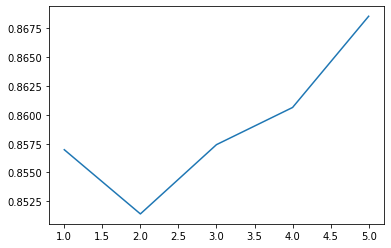

In [323]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1, n_members+1)]
pyplot.plot(x_axis, scores)
pyplot.show()